In [ ]:
# arrays and dataframes
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# time series - statsmodels
from statsmodels.tsa.filters.hp_filter import hpfilter  # Hodrick Prescott filter for cyclic & trend separation
from statsmodels.tsa.seasonal import seasonal_decompose # Error Trend Seasonality decomposition

# holt winters 
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   # single exponential smoothing as in ewm of pandas
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing

# consistent plot size wherever not specifiied
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['axes.labelsize'] = 12

In [2]:
# BKKG Preprocessing 
bmkg_data = pd.read_csv('/run/media/cryptedlm/localdisk/Kuliah/Tugas Akhir/Dataset/BMKG/Stasiun Klimatologi Aceh/CSV/BMKG_Data_2005.csv', index_col=0,parse_dates=True)

In [3]:
bmkg_data.head(20)

,Year,Month,Day,TN,TX,TAVG,RH_AVG,RR,SS,FF_X,DDD_X,FF_AVG,DDD_CAR
Date,,,,,,,,,,,,,
2005-01-01,2005,1,1,21,33.2,25.7,90,8888,5.0,-,-,-,-
2005-01-02,2005,1,2,22,33,26.3,90,8888,0.0,-,-,-,-
2005-01-03,2005,1,3,21,33,26.5,90,8888,3.0,-,-,-,-
2005-01-04,2005,1,4,22,33,26.5,89,2,3.1,-,-,-,-
2005-01-05,2005,1,5,21,32.8,25.6,88,8888,7.5,-,-,-,-
2005-01-06,2005,1,6,22,32,27.1,89,8888,5.0,-,-,-,-
2005-01-07,2005,1,7,21,32.4,27.5,89,4,5.0,-,-,-,-
2005-01-08,2005,1,8,22,33,26.6,90,8888,0.0,-,-,-,-
2005-01-09,2005,1,9,21,33,25.7,91,8888,2.4,-,-,-,-


In [4]:
print(bmkg_data.dtypes)

Year         int64
Month        int64
Day          int64
TN          object
TX          object
TAVG       float64
RH_AVG       int64
RR           int64
SS         float64
FF_X        object
DDD_X       object
FF_AVG      object
DDD_CAR     object
dtype: object


In [5]:
# List kolom yang harus diperbaiki
cols_to_fix = ['TN', 'TX', 'FF_X', 'DDD_X', 'FF_AVG']

# Bersihkan: ganti '-' jadi NaN, lalu convert ke numeric
for col in cols_to_fix:
    bmkg_data[col] = pd.to_numeric(bmkg_data[col], errors='coerce')
print(bmkg_data.dtypes)

Year         int64
Month        int64
Day          int64
TN         float64
TX         float64
TAVG       float64
RH_AVG       int64
RR           int64
SS         float64
FF_X       float64
DDD_X      float64
FF_AVG     float64
DDD_CAR     object
dtype: object


In [6]:
print(bmkg_data.dtypes)

Year         int64
Month        int64
Day          int64
TN         float64
TX         float64
TAVG       float64
RH_AVG       int64
RR           int64
SS         float64
FF_X       float64
DDD_X      float64
FF_AVG     float64
DDD_CAR     object
dtype: object


In [7]:
# Menangani nilai 8888 dan 9999 (kode untuk missing value)
for col in bmkg_data.columns:
    if bmkg_data[col].dtype != 'object':  # Hanya ubah kolom numerik
        bmkg_data[col] = bmkg_data[col].replace([8888, 9999], np.nan)

In [8]:
# Mengecek persentase missing values di setiap kolom
missing_percentage = bmkg_data.isna().mean() * 100
print("Persentase Missing Values per Kolom:")
print(missing_percentage)

Persentase Missing Values per Kolom:
Year        0.000000
Month       0.000000
Day         0.000000
TN          0.273973
TX          0.273973
TAVG        0.000000
RH_AVG      0.000000
RR         66.027397
SS          0.000000
FF_X        3.835616
DDD_X      11.780822
FF_AVG      3.835616
DDD_CAR     0.000000
dtype: float64


In [9]:
# Menampilkan data setelah penanganan missing values
print("\nData setelah penanganan missing values:")
print(bmkg_data.head())


Data setelah penanganan missing values:
            Year  Month  Day    TN    TX  TAVG  RH_AVG   RR   SS  FF_X  DDD_X  \
Date                                                                            
2005-01-01  2005      1    1  21.0  33.2  25.7      90  NaN  5.0   NaN    NaN   
2005-01-02  2005      1    2  22.0  33.0  26.3      90  NaN  0.0   NaN    NaN   
2005-01-03  2005      1    3  21.0  33.0  26.5      90  NaN  3.0   NaN    NaN   
2005-01-04  2005      1    4  22.0  33.0  26.5      89  2.0  3.1   NaN    NaN   
2005-01-05  2005      1    5  21.0  32.8  25.6      88  NaN  7.5   NaN    NaN   

            FF_AVG DDD_CAR  
Date                        
2005-01-01     NaN       -  
2005-01-02     NaN       -  
2005-01-03     NaN       -  
2005-01-04     NaN       -  
2005-01-05     NaN       -  


In [10]:
# Memilih kolom numerik untuk smoothing (exclude DDD_CAR karena arah mata angin)
numeric_cols = bmkg_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'DDD_CAR' in numeric_cols:
    numeric_cols.remove('DDD_CAR')

In [11]:
# Fungsi untuk menerapkan SMA (Simple Moving Average)
def apply_sma(series, window):
    return series.rolling(window=window).mean()

# Fungsi untuk menerapkan EWMA (Exponentially Weighted Moving Average)
def apply_ewma(series, span):
    return series.ewm(span=span).mean()

# Memilih beberapa kolom untuk visualisasi (contoh: TAVG, RH_AVG)
columns_to_visualize = ['TAVG']

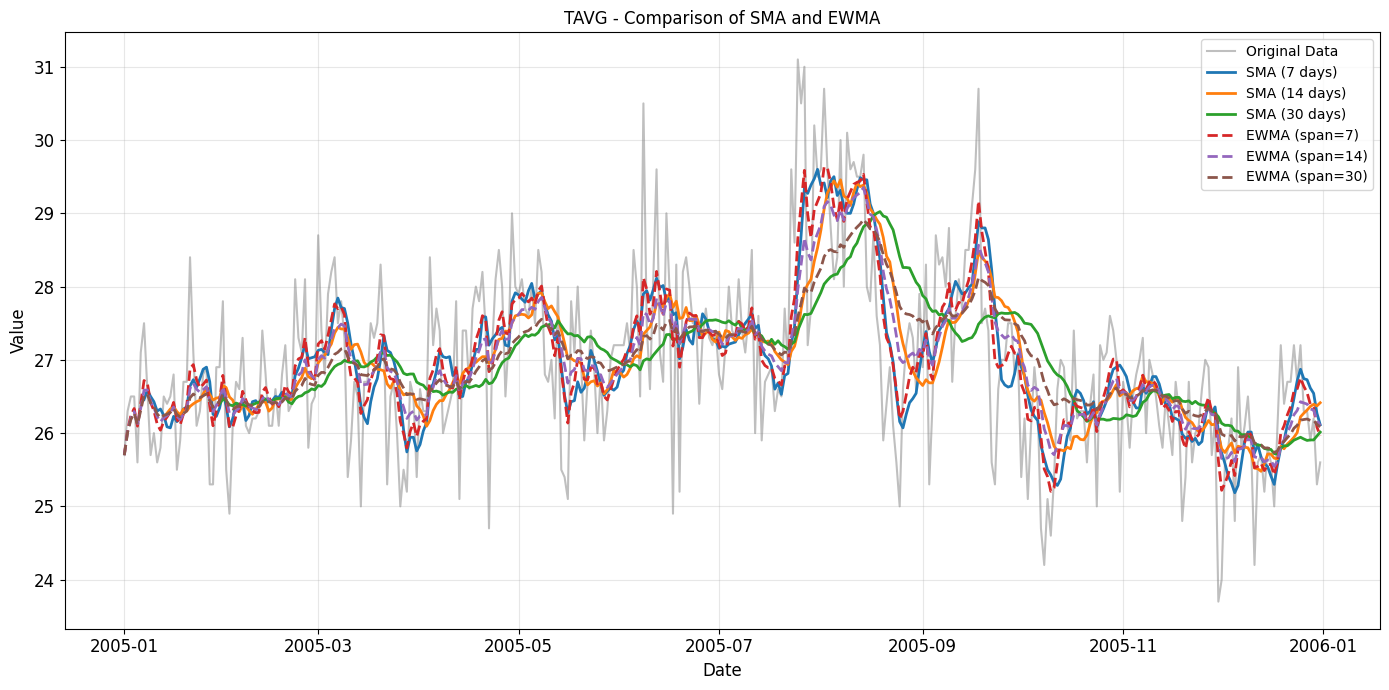

In [12]:
# Menerapkan SMA dan EWMA pada kolom yang dipilih
for col in columns_to_visualize:
    plt.figure(figsize=(14, 7))
    
    # Data asli
    plt.plot(bmkg_data.index, bmkg_data[col], label='Original Data', color='gray', alpha=0.5)
    
    # SMA dengan berbagai windows
    for window in [7, 14, 30]:
        sma = apply_sma(bmkg_data[col], window)
        plt.plot(bmkg_data.index, sma, label=f'SMA ({window} days)', linewidth=2)
    
    # EWMA dengan berbagai spans
    for span in [7, 14, 30]:
        ewma = apply_ewma(bmkg_data[col], span)
        plt.plot(bmkg_data.index, ewma, label=f'EWMA (span={span})', linestyle='--', linewidth=2)
    
    plt.grid(True, alpha=0.3)
    plt.title(f'{col} - Comparison of SMA and EWMA')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

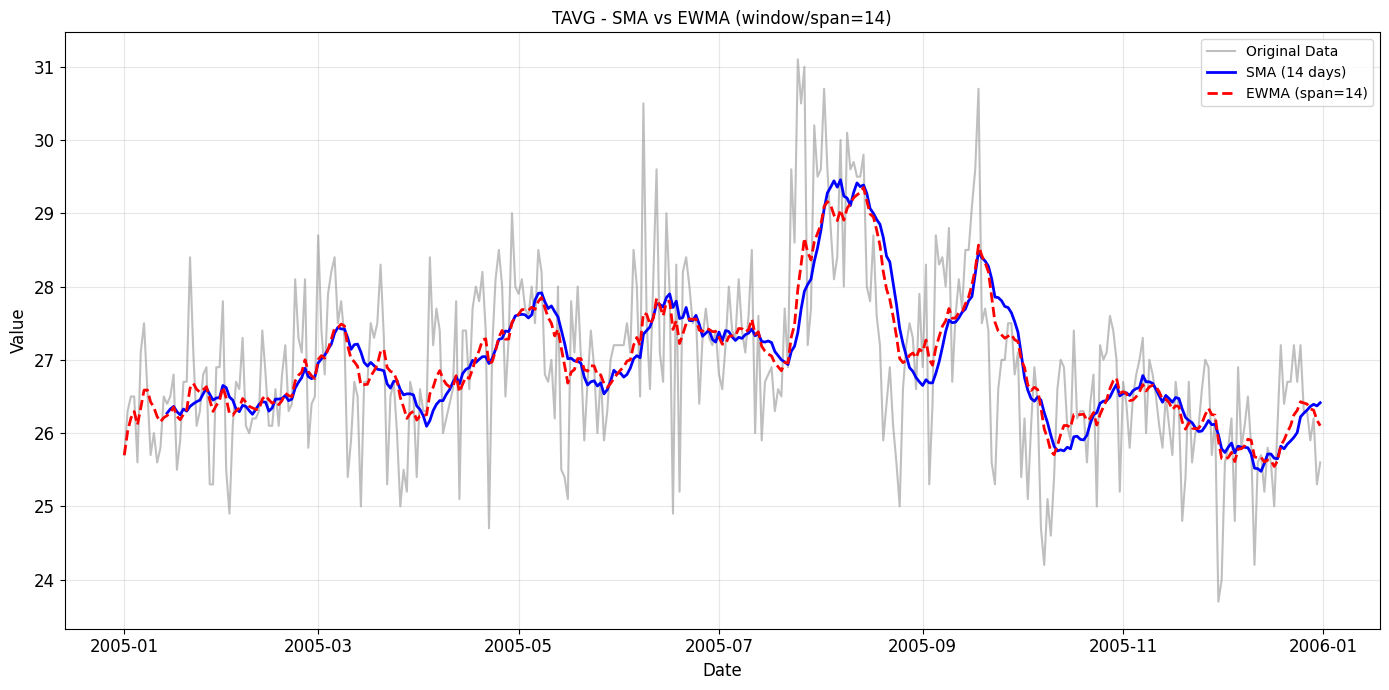

In [13]:
# Membandingkan SMA dan EWMA pada satu kolom (misalnya TAVG)
col_to_compare = 'TAVG'
window_size = 14
span_value = 14

plt.figure(figsize=(14, 7))
plt.plot(bmkg_data.index, bmkg_data[col_to_compare], label='Original Data', color='gray', alpha=0.5)
plt.plot(bmkg_data.index, apply_sma(bmkg_data[col_to_compare], window_size), 
         label=f'SMA ({window_size} days)', color='blue', linewidth=2)
plt.plot(bmkg_data.index, apply_ewma(bmkg_data[col_to_compare], span_value), 
         label=f'EWMA (span={span_value})', color='red', linewidth=2, linestyle='--')

plt.grid(True, alpha=0.3)
plt.title(f'{col_to_compare} - SMA vs EWMA (window/span={window_size})')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
# Analisis residual untuk melihat kualitas smoothing
col_for_residual = 'TAVG'
window_size = 14
span_value = 14

sma_values = apply_sma(bmkg_data[col_for_residual], window_size)
ewma_values = apply_ewma(bmkg_data[col_for_residual], span_value)

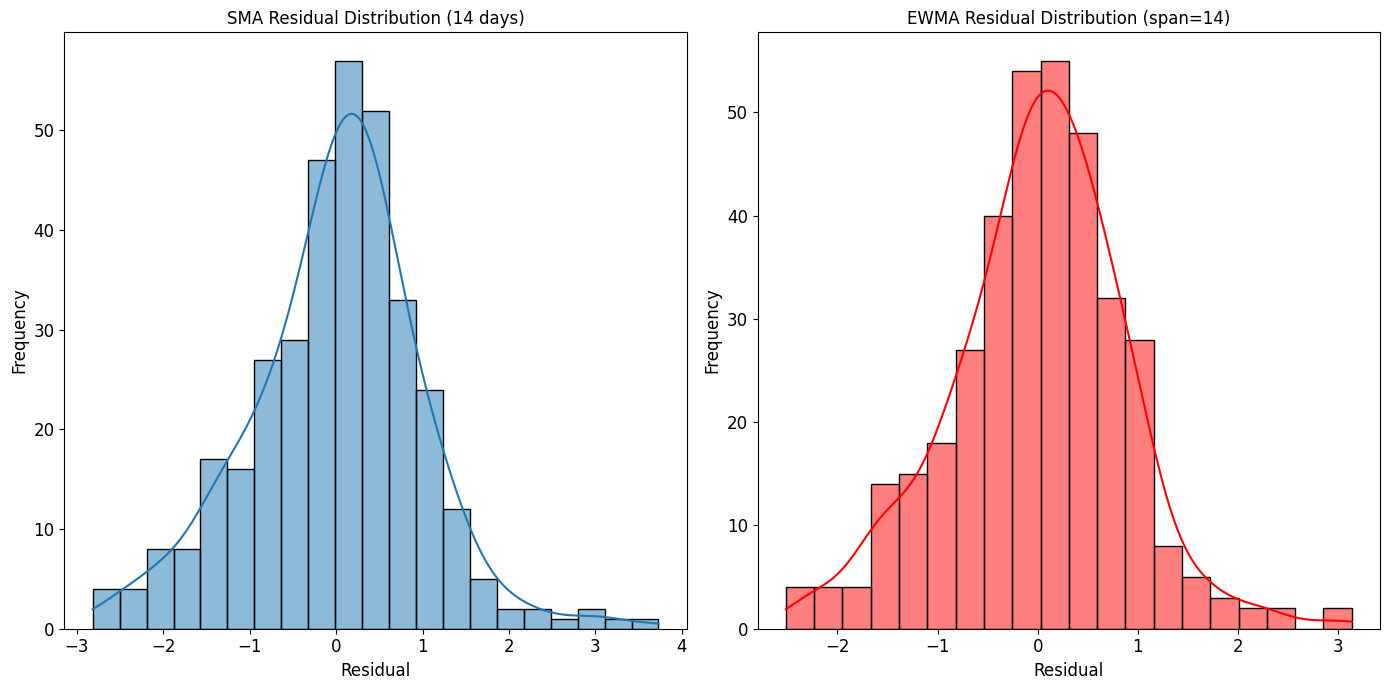

In [15]:
# Hitung residual (selisih antara data asli dan hasil smoothing)
sma_residual = bmkg_data[col_for_residual] - sma_values
ewma_residual = bmkg_data[col_for_residual] - ewma_values

# Menampilkan distribusi residual
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.histplot(sma_residual.dropna(), kde=True, label='SMA Residual')
plt.title(f'SMA Residual Distribution ({window_size} days)')
plt.xlabel('Residual')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(ewma_residual.dropna(), kde=True, color='red', label='EWMA Residual')
plt.title(f'EWMA Residual Distribution (span={span_value})')
plt.xlabel('Residual')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [16]:
# 1. Imputasi Missing Values untuk analisis time series
# Menggunakan forward fill dan backward fill untuk data yang akan dianalisis
bmkg_data_filled = bmkg_data.fillna(method='ffill').fillna(method='bfill')

/tmp/ipykernel_55950/4043677612.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  bmkg_data_filled = bmkg_data.fillna(method='ffill').fillna(method='bfill')


In [17]:
# 2. Time Series Decomposition dengan HP Filter
# Pilih kolom untuk dekomposisi
col_for_decomp = 'TAVG'

In [18]:
# Menerapkan HP Filter (lambda=1600 adalah standar untuk data kuartalan)
# Untuk data harian, nilai lambda yang lebih besar seperti 129600 bisa digunakan
cycle, trend = hpfilter(bmkg_data_filled[col_for_decomp], lamb=129600)

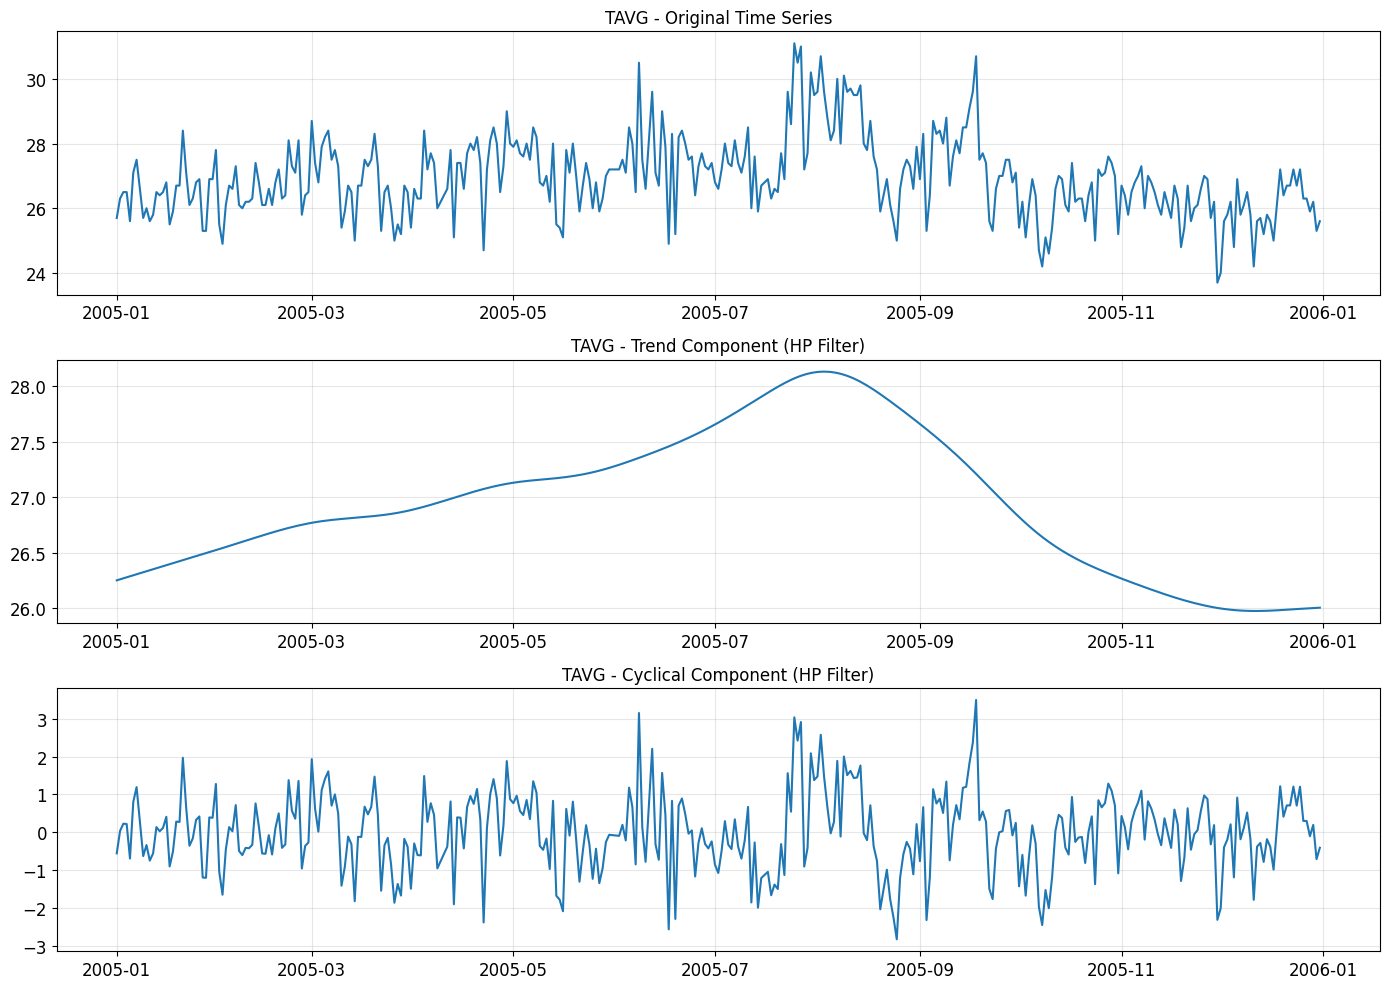

In [19]:
# Visualisasi hasil dekomposisi HP Filter
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(bmkg_data_filled.index, bmkg_data_filled[col_for_decomp])
plt.title(f'{col_for_decomp} - Original Time Series')
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(bmkg_data_filled.index, trend)
plt.title(f'{col_for_decomp} - Trend Component (HP Filter)')
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
plt.plot(bmkg_data_filled.index, cycle)
plt.title(f'{col_for_decomp} - Cyclical Component (HP Filter)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


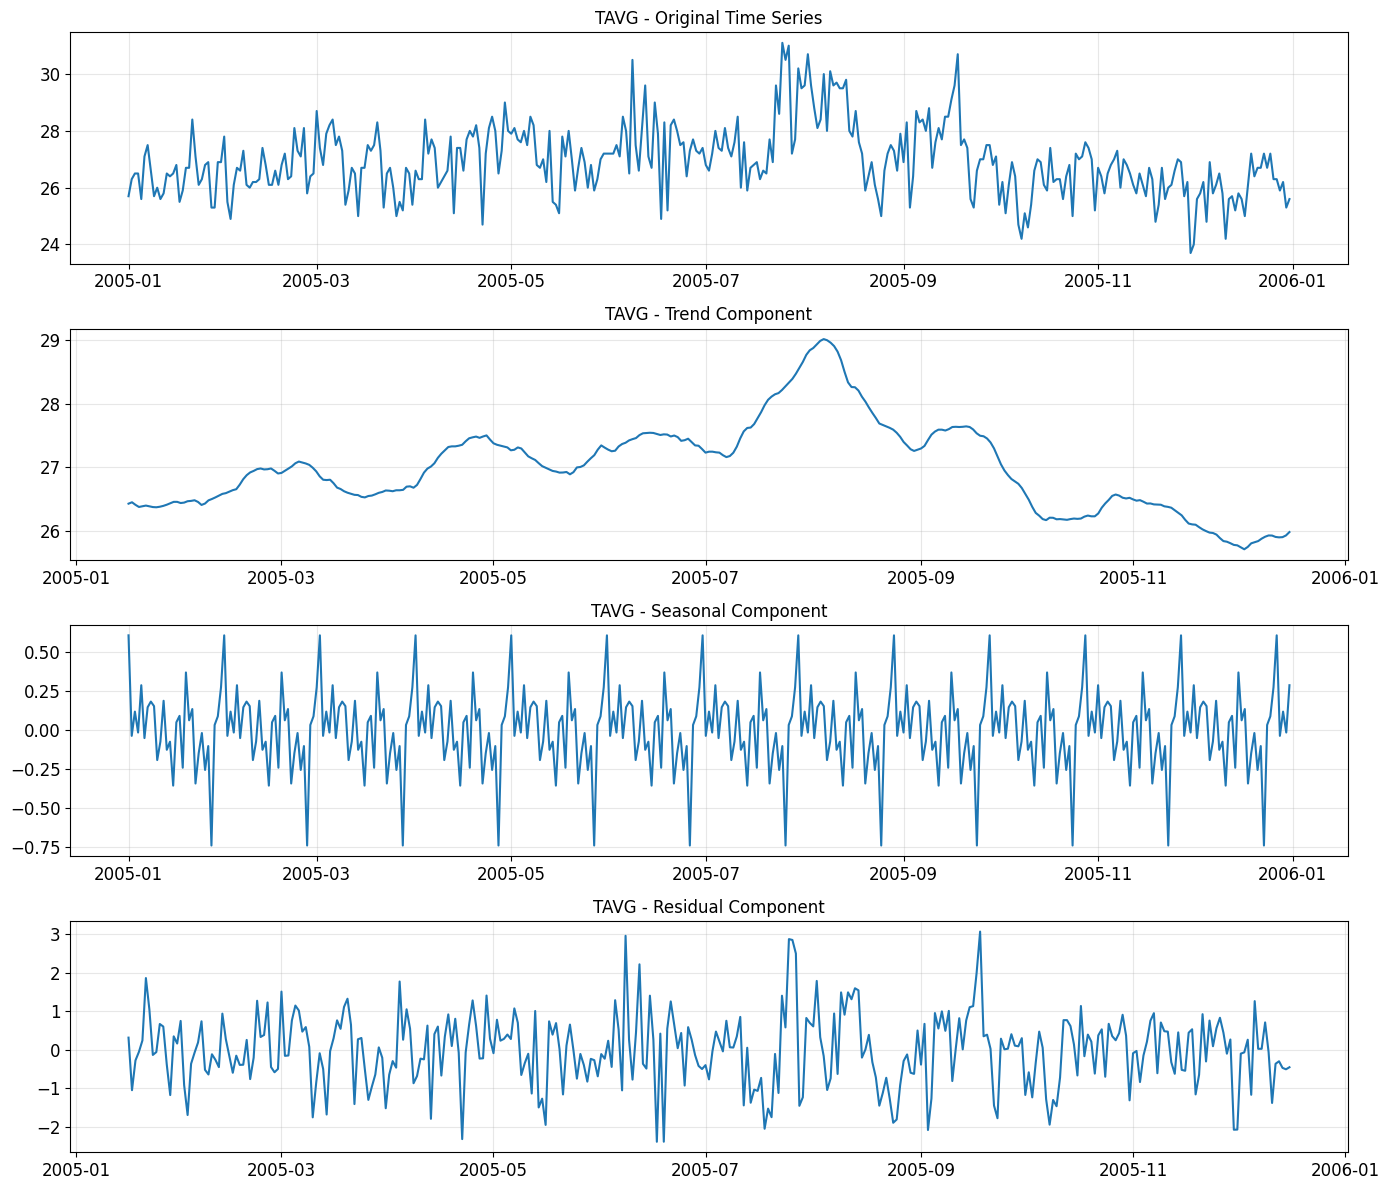

In [20]:
# 3. Seasonal Decomposition (alternatif HP Filter)
# Seasonal decomposition menggunakan model additive

# Apa beda multiplikatif dan aditive

decomposition = seasonal_decompose(bmkg_data_filled[col_for_decomp], model='additive', period=30)

# Visualisasi hasil seasonal decomposition
plt.figure(figsize=(14, 12))

plt.subplot(4, 1, 1)
plt.plot(bmkg_data_filled.index, bmkg_data_filled[col_for_decomp])
plt.title(f'{col_for_decomp} - Original Time Series')
plt.grid(True, alpha=0.3)

plt.subplot(4, 1, 2)
plt.plot(bmkg_data_filled.index, decomposition.trend)
plt.title(f'{col_for_decomp} - Trend Component')
plt.grid(True, alpha=0.3)

plt.subplot(4, 1, 3)
plt.plot(bmkg_data_filled.index, decomposition.seasonal)
plt.title(f'{col_for_decomp} - Seasonal Component')
plt.grid(True, alpha=0.3)

plt.subplot(4, 1, 4)
plt.plot(bmkg_data_filled.index, decomposition.resid)
plt.title(f'{col_for_decomp} - Residual Component')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# 4. Implementasi Holt-Winters Exponential Smoothing Methods

# 4.1 Simple Exponential Smoothing (SES)
print("\n=== Simple Exponential Smoothing (Single) ===")
# Menggunakan TAVG sebagai contoh
ses_model = SimpleExpSmoothing(bmkg_data_filled[col_for_decomp]).fit(
    optimized=True,
    remove_bias=True
)

# Mendapatkan parameter optimal
print(f"Optimal Alpha: {ses_model.params['smoothing_level']:.4f}")

# Fitted values
ses_fitted = ses_model.fittedvalues

# Hitung MSE secara manual
ses_mse = np.mean((bmkg_data_filled[col_for_decomp] - ses_fitted) ** 2)
print(f"Mean Squared Error: {ses_mse:.4f}")

# 4.2 Double Exponential Smoothing (Holt's Method)
print("\n=== Double Exponential Smoothing (Holt's Method) ===")
des_model = ExponentialSmoothing(
    bmkg_data_filled[col_for_decomp],
    trend='add',  # 'add' untuk trend aditif
    seasonal=None  # Tidak ada komponen seasonal
).fit(optimized=True, remove_bias=True)

# Mendapatkan parameter optimal
print(f"Optimal Alpha (level): {des_model.params['smoothing_level']:.4f}")
print(f"Optimal Beta (trend): {des_model.params['smoothing_trend']:.4f}")

# Fitted values
des_fitted = des_model.fittedvalues

# Hitung MSE secara manual
des_mse = np.mean((bmkg_data_filled[col_for_decomp] - des_fitted) ** 2)
print(f"Mean Squared Error: {des_mse:.4f}")

# 4.3 Triple Exponential Smoothing (Holt-Winters Method)
print("\n=== Triple Exponential Smoothing (Holt-Winters Method) ===")
# Mencoba dengan beberapa seasonal_periods yang berbeda untuk menentukan yang terbaik
seasonal_periods_list = [7, 30, 365]  # Mingguan, bulanan, tahunan

tes_models = {}
tes_fitted_values = {}
tes_mse_dict = {}

for seasonal_period in seasonal_periods_list:
    try:
        print(f"\nTrying seasonal period: {seasonal_period}")
        tes_model = ExponentialSmoothing(
            bmkg_data_filled[col_for_decomp],
            trend='add',  # 'add' untuk trend aditif
            seasonal='add',  # 'add' untuk seasonal aditif
            seasonal_periods=seasonal_period
        ).fit(optimized=True, remove_bias=True)
        
        # Simpan model dan fitted values
        tes_models[seasonal_period] = tes_model
        tes_fitted_values[seasonal_period] = tes_model.fittedvalues
        
        # Hitung MSE secara manual
        tes_mse = np.mean((bmkg_data_filled[col_for_decomp] - tes_model.fittedvalues) ** 2)
        tes_mse_dict[seasonal_period] = tes_mse
        
        # Cetak parameter
        print(f"Optimal Alpha (level): {tes_model.params['smoothing_level']:.4f}")
        print(f"Optimal Beta (trend): {tes_model.params['smoothing_trend']:.4f}")
        print(f"Optimal Gamma (seasonal): {tes_model.params['smoothing_seasonal']:.4f}")
        print(f"Mean Squared Error: {tes_mse:.4f}")
    except Exception as e:
        print(f"Error with seasonal period {seasonal_period}: {str(e)}")

# Temukan seasonal period terbaik berdasarkan MSE
best_period = None
if tes_mse_dict:
    best_period = min(tes_mse_dict, key=tes_mse_dict.get)
    print(f"\nBest seasonal period based on MSE: {best_period}")
    print(f"MSE: {tes_mse_dict[best_period]:.4f}")


=== Simple Exponential Smoothing (Single) ===
Optimal Alpha: 0.3446
Mean Squared Error: 0.9322

=== Double Exponential Smoothing (Holt's Method) ===
Optimal Alpha (level): 0.3417
Optimal Beta (trend): 0.0000
Mean Squared Error: 0.9311

=== Triple Exponential Smoothing (Holt-Winters Method) ===

Trying seasonal period: 7


/home/cryptedlm/python-venv/tugas-akhir/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cryptedlm/python-venv/tugas-akhir/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cryptedlm/python-venv/tugas-akhir/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Optimal Alpha (level): 0.3446
Optimal Beta (trend): 0.0000
Optimal Gamma (seasonal): 0.0000
Mean Squared Error: 0.9198

Trying seasonal period: 30


/home/cryptedlm/python-venv/tugas-akhir/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Optimal Alpha (level): 0.3539
Optimal Beta (trend): 0.0000
Optimal Gamma (seasonal): 0.0000
Mean Squared Error: 0.8771

Trying seasonal period: 365
Error with seasonal period 365: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.

Best seasonal period based on MSE: 30
MSE: 0.8771


/home/cryptedlm/python-venv/tugas-akhir/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


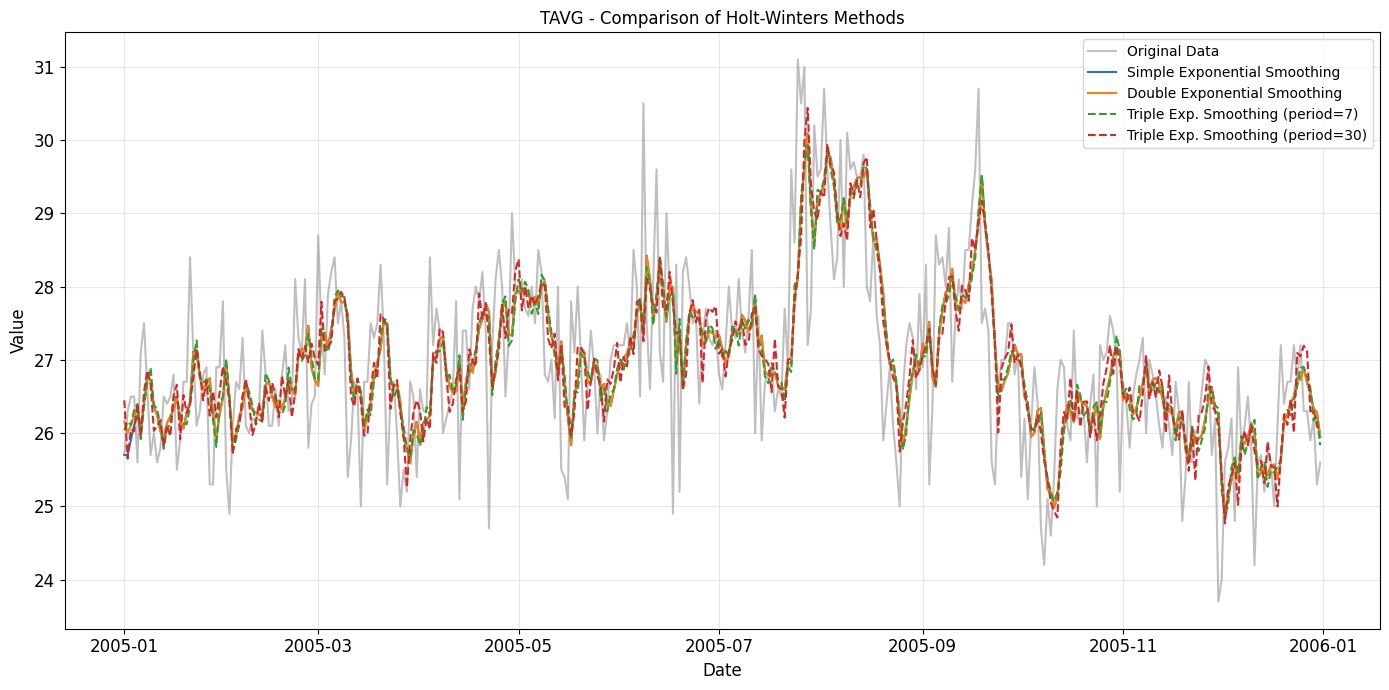

In [22]:
# 5. Visualisasi perbandingan semua metode Holt-Winters
plt.figure(figsize=(14, 7))

# Data asli
plt.plot(bmkg_data_filled.index, bmkg_data_filled[col_for_decomp], 
         label='Original Data', color='gray', alpha=0.5)

# Simple Exponential Smoothing
plt.plot(bmkg_data_filled.index, ses_fitted, 
         label='Simple Exponential Smoothing', linewidth=1.5)

# Double Exponential Smoothing
plt.plot(bmkg_data_filled.index, des_fitted, 
         label='Double Exponential Smoothing', linewidth=1.5)

# Triple Exponential Smoothing (untuk setiap seasonal period yang berhasil)
for period, fitted in tes_fitted_values.items():
    plt.plot(bmkg_data_filled.index, fitted, 
             label=f'Triple Exp. Smoothing (period={period})', 
             linewidth=1.5, linestyle='--')

plt.grid(True, alpha=0.3)
plt.title(f'{col_for_decomp} - Comparison of Holt-Winters Methods')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# 6. Residual Analysis untuk setiap metode
residuals = {
    'Simple': bmkg_data_filled[col_for_decomp] - ses_fitted,
    'Double': bmkg_data_filled[col_for_decomp] - des_fitted,
}



Best Triple Exponential model uses seasonal period: 7


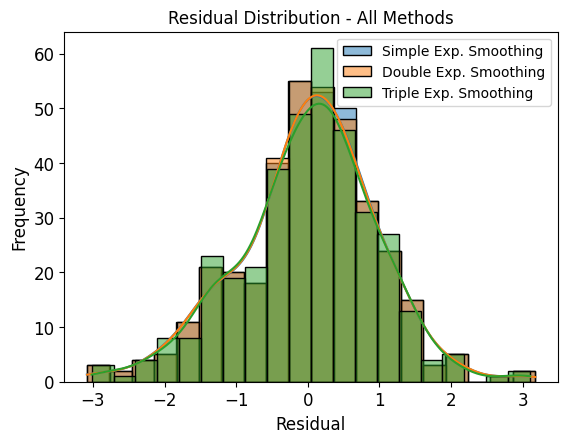

In [24]:
# Cari best seasonal period
best_period = list(tes_fitted_values.keys())[0] if tes_fitted_values else None

if best_period:
    residuals['Triple'] = bmkg_data_filled[col_for_decomp] - tes_fitted_values[best_period]
    print(f"\nBest Triple Exponential model uses seasonal period: {best_period}")

# Visualisasi residual
plt.figure(figsize=(14, 10))

# Plot histogram residual untuk masing-masing metode
plt.subplot(2, 2, 1)
for name, resid in residuals.items():
    sns.histplot(resid.dropna(), kde=True, label=f'{name} Exp. Smoothing')
plt.title('Residual Distribution - All Methods')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.legend()


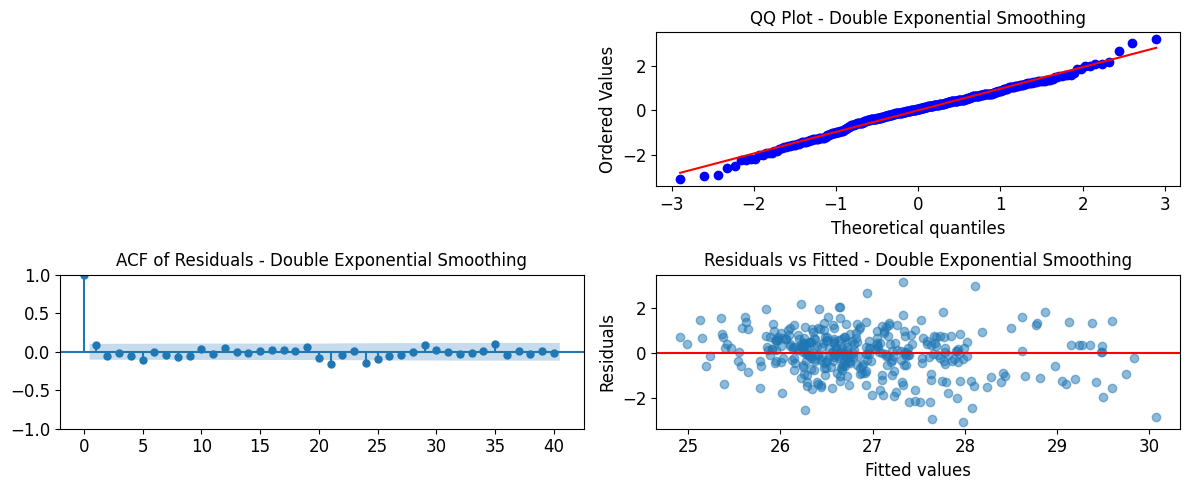

In [25]:
# Plot QQ plot untuk Double Exponential Smoothing (sebagai contoh)
plt.subplot(2, 2, 2)
from scipy import stats
stats.probplot(residuals['Double'].dropna(), plot=plt)
plt.title('QQ Plot - Double Exponential Smoothing')

# Plot ACF dari residual untuk Double Exponential Smoothing
plt.subplot(2, 2, 3)
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals['Double'].dropna(), lags=40, alpha=0.05, ax=plt.gca())
plt.title('ACF of Residuals - Double Exponential Smoothing')

# Plot residual vs fitted
plt.subplot(2, 2, 4)
plt.scatter(des_fitted, residuals['Double'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals vs Fitted - Double Exponential Smoothing')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()


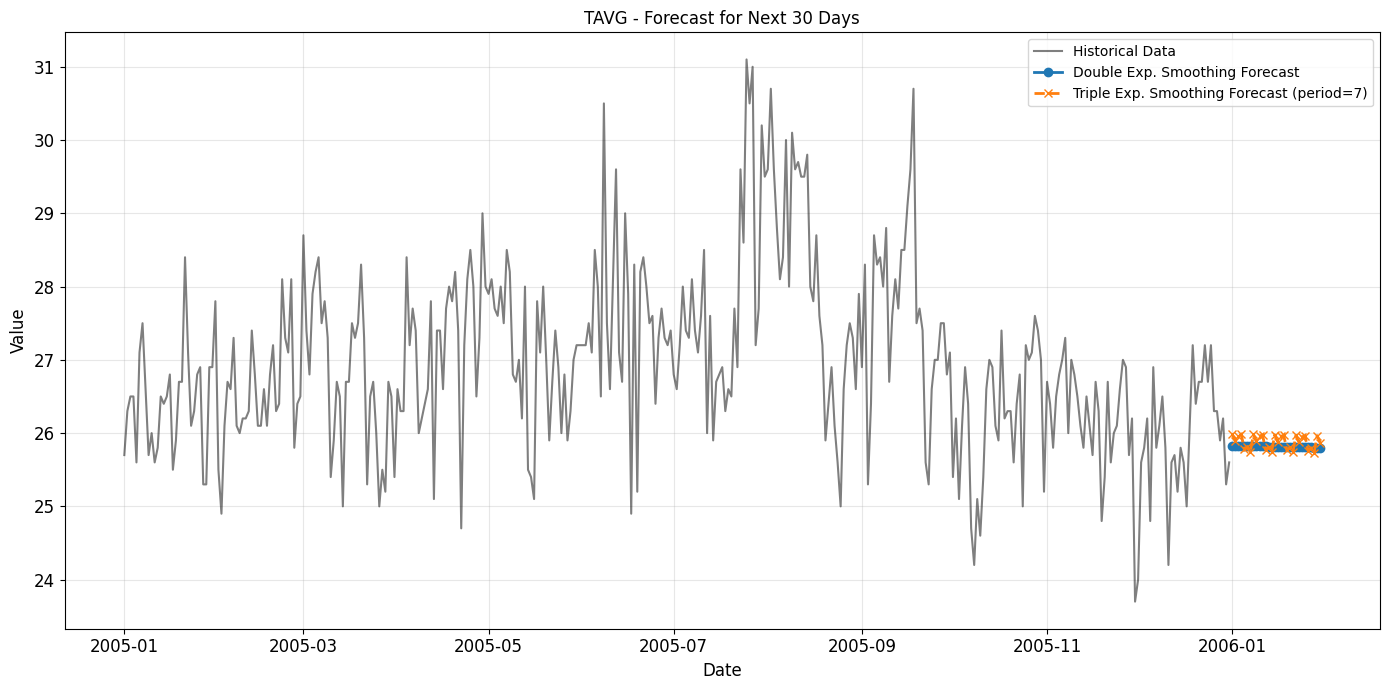


=== Model Evaluation ===
Simple Exponential Smoothing:
  Mean Squared Error (MSE): 0.9322
  Root Mean Squared Error (RMSE): 0.9655
  Mean Absolute Error (MAE): 0.7396
  R-squared (R²): 0.3805
Double Exponential Smoothing:
  Mean Squared Error (MSE): 0.9311
  Root Mean Squared Error (RMSE): 0.9650
  Mean Absolute Error (MAE): 0.7395
  R-squared (R²): 0.3811
Triple Exponential Smoothing (period=7):
  Mean Squared Error (MSE): 0.9198
  Root Mean Squared Error (RMSE): 0.9591
  Mean Absolute Error (MAE): 0.7405
  R-squared (R²): 0.3886

Best model based on RMSE: TES
RMSE: 0.9591


In [26]:
# 7. Forecast untuk periode ke depan (contoh: 30 hari)
forecast_horizon = 30

# Membuat index untuk forecast
last_date = bmkg_data_filled.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')

# Forecast menggunakan metode terbaik (misalkan Double Exponential)
des_forecast = des_model.forecast(forecast_horizon)

# Jika Triple Exponential berhasil, gunakan model dengan seasonal period terbaik
tes_forecast = None
if best_period:
    tes_forecast = tes_models[best_period].forecast(forecast_horizon)

# Visualisasi forecast
plt.figure(figsize=(14, 7))

# Data asli
plt.plot(bmkg_data_filled.index, bmkg_data_filled[col_for_decomp], 
         label='Historical Data', color='black', alpha=0.5)

# Double Exponential forecast
plt.plot(forecast_index, des_forecast, 
         label='Double Exp. Smoothing Forecast', linewidth=2, marker='o')

# Triple Exponential forecast (jika tersedia)
if tes_forecast is not None:
    plt.plot(forecast_index, tes_forecast, 
             label=f'Triple Exp. Smoothing Forecast (period={best_period})', 
             linewidth=2, linestyle='--', marker='x')

plt.grid(True, alpha=0.3)
plt.title(f'{col_for_decomp} - Forecast for Next {forecast_horizon} Days')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

# 8. Evaluasi Model menggunakan metrics
print("\n=== Model Evaluation ===")
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function untuk evaluasi model
def evaluate_model(actual, fitted, model_name):
    # Hapus NaN values
    valid_idx = ~np.isnan(fitted) & ~np.isnan(actual)
    actual_valid = actual[valid_idx]
    fitted_valid = fitted[valid_idx]
    
    if len(actual_valid) == 0:
        print(f"{model_name}: Not enough valid data points for evaluation")
        return {'mse': np.nan, 'rmse': np.nan, 'mae': np.nan, 'r2': np.nan}
    
    mse = mean_squared_error(actual_valid, fitted_valid)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_valid, fitted_valid)
    r2 = r2_score(actual_valid, fitted_valid)
    
    print(f"{model_name}:")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  R-squared (R²): {r2:.4f}")
    
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

# Evaluasi setiap model
actual = bmkg_data_filled[col_for_decomp]
results = {}

results['SES'] = evaluate_model(actual, ses_fitted, "Simple Exponential Smoothing")
results['DES'] = evaluate_model(actual, des_fitted, "Double Exponential Smoothing")

if best_period:
    results['TES'] = evaluate_model(
        actual, 
        tes_fitted_values[best_period], 
        f"Triple Exponential Smoothing (period={best_period})"
    )

# Tampilkan model terbaik berdasarkan RMSE
if results:
    valid_results = {k: v for k, v in results.items() if not np.isnan(v['rmse'])}
    if valid_results:
        best_model = min(valid_results, key=lambda x: valid_results[x]['rmse'])
        print(f"\nBest model based on RMSE: {best_model}")
        print(f"RMSE: {valid_results[best_model]['rmse']:.4f}")
    else:
        print("\nNo valid models to compare")
else:
    print("\nNo results to evaluate")